# Data Science content

The goal of this project is to help an education organization that specializes is in Data Science determine what type of content they should offer using data gotten from Data Science Stack Exchange.

Upon researching the website we deicide that "Tags" (a list of tags (keywords or labels that categorize questions) section could be suitable in helping solve our problem.

From observing the table names in the Stack Exchange Data Explorer (SEDE), we find some tables that look relevant to what we intend to accomplish;
* TagSynonyms
* Tags
* Posts
* PostTags

After querying these tables we settle on using the Posts table as it contains data most relevant to our goal.

## Extracting the data

We ran the following query to get the data we need:

SELECT Id, CreationDate,Score, ViewCount, Tags, AnswerCount, FavoriteCount  
FROM posts  
WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# importing the data we got from the query in SEDE
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

In [3]:
questions.head(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN


In [4]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


We notice only the "FavoriteCount" column has null values and this could be because no user added the question to their favourite list, so the missing values can be replaced with 0.

We also noticed that the in Tags column each tag in enclosed in symbols ('<' & '>'), we know that each question is not allowed more than 5 tags.

In [5]:
# filling null values in FavouriteCount with 0 and casting as integer column
questions.fillna(value={"FavoriteCount": 0}, inplace=True)
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

In [6]:
# cleaning the Tags and splitting
questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")
questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
4335,49680,2019-04-21 14:53:44,1,67,"[python, hyperparameter-tuning, bayesian, grid...",1,0
1660,57463,2019-08-13 03:43:35,2,51,"[machine-learning, k-nn]",0,0
6655,63931,2019-11-28 12:52:28,1,17,[keras],0,1


In [7]:
# creating a counter for each tag
tag_count = {}

for tags in questions["Tags"]:
    for tag in tags:
        if tag not in tag_count:
            tag_count[tag] = 1
        else:
            tag_count[tag] += 1

In [8]:
# convert our counter into a dataframe to be viwed easily
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "count"}, inplace=True)
tag_count.head()

,count
tableau,9
dqn,36
nl2sql,1
confusion-matrix,27
web-scrapping,8


In [9]:
# saving the top 20 tags
top20_used = tag_count.sort_values(by="count", ascending=False ).head(20)
top20_used

,count
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493
cnn,489


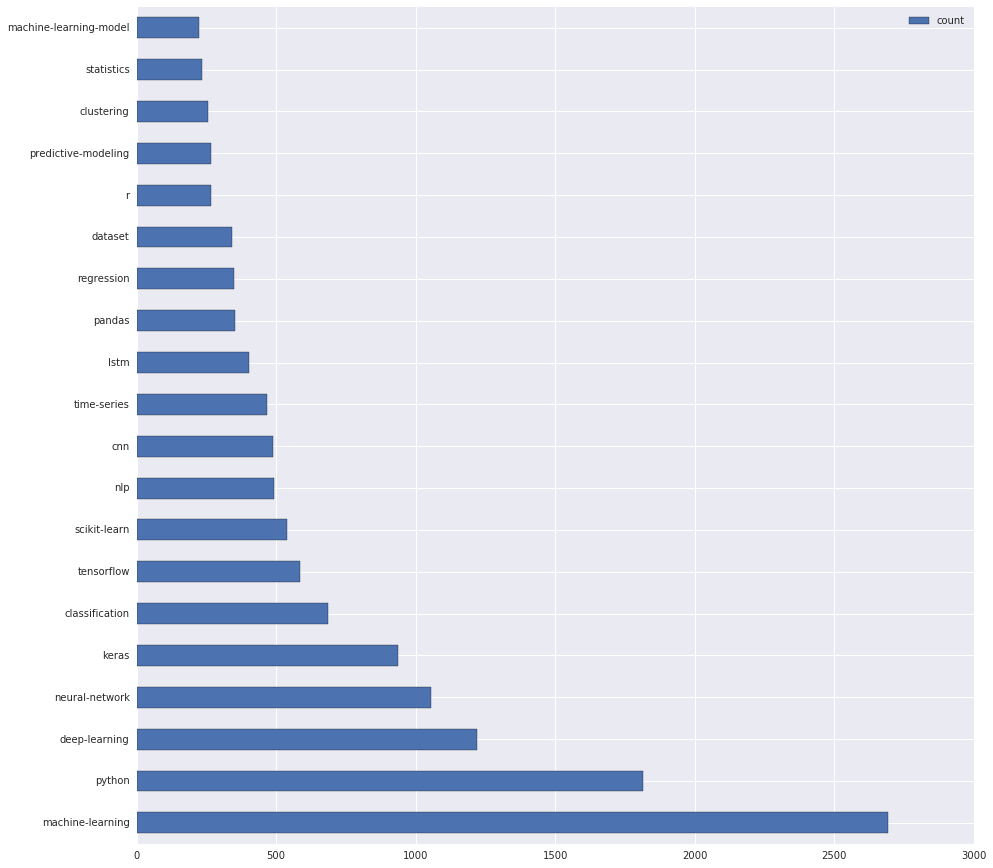

In [10]:
top20_used.plot(kind="barh", figsize=(15,15));

We observe that there's a rapid change in popularity of tags

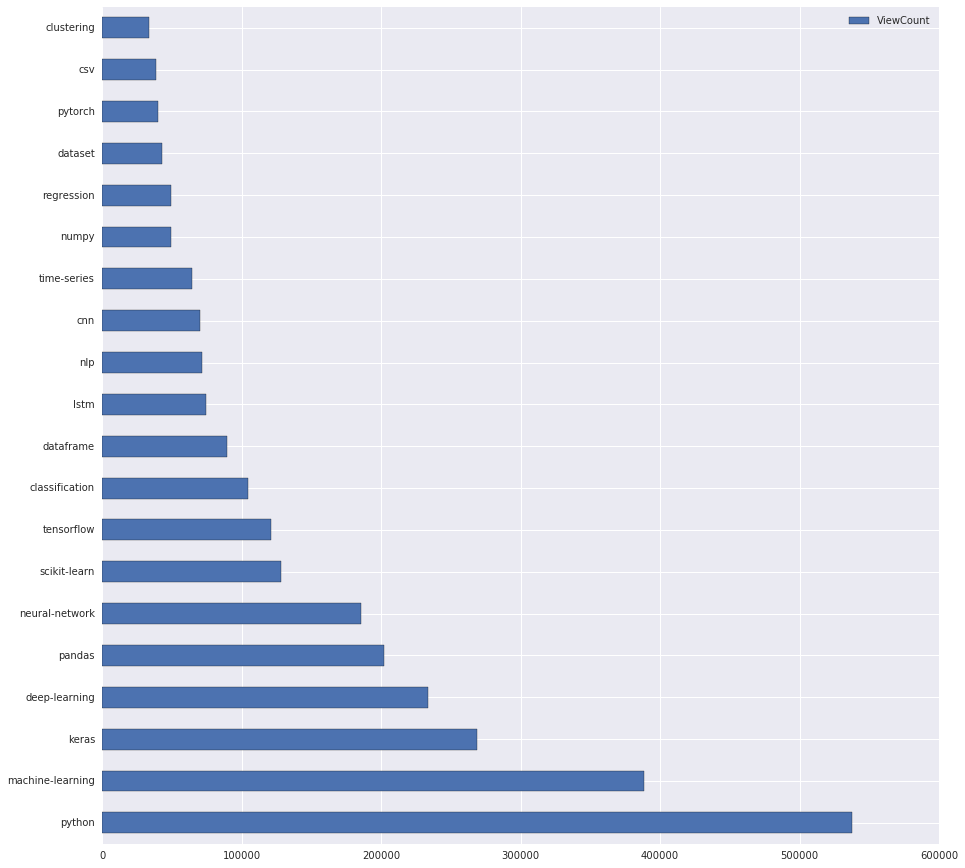

In [11]:
# We repeat our "tag used" analysis on views for the tags
tag_view_count = {}

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag not in tag_view_count:
            tag_view_count[tag] = row['ViewCount']
        else:
            tag_view_count[tag] += row['ViewCount']
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

top20_viewed = tag_view_count.sort_values(by="ViewCount", ascending=False).head(20)

top20_viewed.plot(kind="barh", figsize=(15,15));

In [12]:
# merge both dataframes to see which tag in one frame but not in the other
in_used = pd.merge(top20_used, top20_viewed, how="left", left_index=True, right_index=True)

in_used[in_used.isnull().any(axis=1)]

,count,ViewCount
r,268,NaN
predictive-modeling,265,NaN
statistics,234,NaN
machine-learning-model,224,NaN


In [13]:
in_viewed = in_used = pd.merge(top20_used, top20_viewed, how="right", left_index=True, right_index=True)

in_viewed[in_viewed.isnull().any(axis=1)]

,count,ViewCount
dataframe,NaN,89352
numpy,NaN,49767
pytorch,NaN,40240
csv,NaN,38654


In [14]:
# We create a matrix for the tags to find tags most commonly used together
all_tags = list(tag_count.index)

associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[:5,:5]

,tableau,dqn,nl2sql,confusion-matrix,web-scrapping
tableau,NaN,NaN,NaN,NaN,NaN
dqn,NaN,NaN,NaN,NaN,NaN
nl2sql,NaN,NaN,NaN,NaN,NaN
confusion-matrix,NaN,NaN,NaN,NaN,NaN
web-scrapping,NaN,NaN,NaN,NaN,NaN


In [15]:
associations.fillna(0, inplace=True)

for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1

In [16]:
# reduce the matrix to just tags from out top 20 used tags
top20_used_associations = associations.loc[top20_used.index, top20_used.index]

In [17]:
top20_used_associations

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,time-series,lstm,pandas,regression,dataset,r,predictive-modeling,clustering,statistics,machine-learning-model
machine-learning,2693,499,429,366,195,259,106,188,113,124,131,71,62,119,99,63,123,61,89,139
python,499,1814,160,137,280,98,167,235,71,62,105,61,244,59,53,24,35,45,35,37
deep-learning,429,160,1220,305,247,59,136,16,72,160,44,103,1,21,32,5,32,2,12,19
neural-network,366,137,305,1055,235,65,108,24,24,118,33,69,1,42,20,9,13,8,11,10
keras,195,280,247,235,935,58,256,34,23,116,51,133,3,31,13,10,11,0,3,17
classification,259,98,59,65,58,685,20,47,35,20,25,20,3,34,28,10,27,12,19,21
tensorflow,106,167,136,108,256,20,584,15,11,57,9,43,3,9,9,1,6,0,0,9
scikit-learn,188,235,16,24,34,47,15,540,12,0,12,2,37,37,9,1,12,24,6,18
nlp,113,71,72,24,23,35,11,12,493,7,0,19,3,2,11,4,1,9,3,4
cnn,124,62,160,118,116,20,57,0,7,489,8,24,1,6,11,2,6,0,1,4


In [18]:
# We replace cells that align with the same name as columns and rows with Nan
for i in range(top20_used_associations.shape[0]):
    top20_used_associations.iloc[i,i] = pd.np.NaN

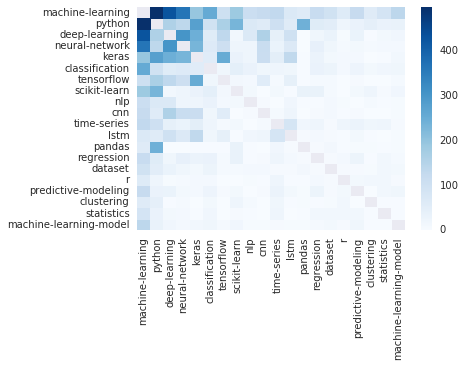

In [19]:
# we plot a heat map to give a better view of our matrix figsize=(12,8)
plt.figure()
sns.heatmap(top20_used_associations, cmap="Blues", annot=False);

We can see the strongest relationship to the top left of our heat map whic also are tags that are the most commomly used. The strong relationship we see might not be as a result of a any true an actual correlation, but beacuse these tags are used a lot and so more than often end up together because of their individual popularity. 

From experience we see that the tags with high relationships are can practically be tied together.  
Keras, Scikit-learn and Tensorflow are Python libraries used for Deep Learning, which falls under Machine Learning.  
Our recommendation to the organization could be to create Deep Learning content that leverages on Python where the libraries mentioned above are introduced.

In [20]:
# read in the dataset and repeat the clesning steps
questions_ = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])
questions_["Tags"] = questions_["Tags"].str.replace("^<|>$", "").str.split("><")

In [21]:
# create a list and function to help us determine which questions are deep learning related
deep_learning = ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]

def class_deep_learning(tags):
    for tag in tags:
        if tag in deep_learning:
            return 1
    return 0

In [22]:
# create a new column to signify if a question is deep learning related
questions_["DeepLearning"] = questions_["Tags"].apply(class_deep_learning)

questions_.head()

,Id,CreationDate,Tags,DeepLearning
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0


In [23]:
# focusing on questions before 2020
questions_b4_2020 = questions_[questions_["CreationDate"].dt.year < 2020]

In [24]:
# function that determines the quarter of a year in which a question was asked
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

questions_b4_2020["Quarter"] = questions_b4_2020["CreationDate"].apply(fetch_quarter)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [25]:
questions_b4_2020.head(3)

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1


In [26]:
# aggregating the questions per quarter to find out how much was deep learning related
quarterly = questions_b4_2020.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)

In [27]:
quarterly.head(3)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
0,14Q2,9,157,0.057325
1,14Q3,13,189,0.068783
2,14Q4,21,216,0.097222


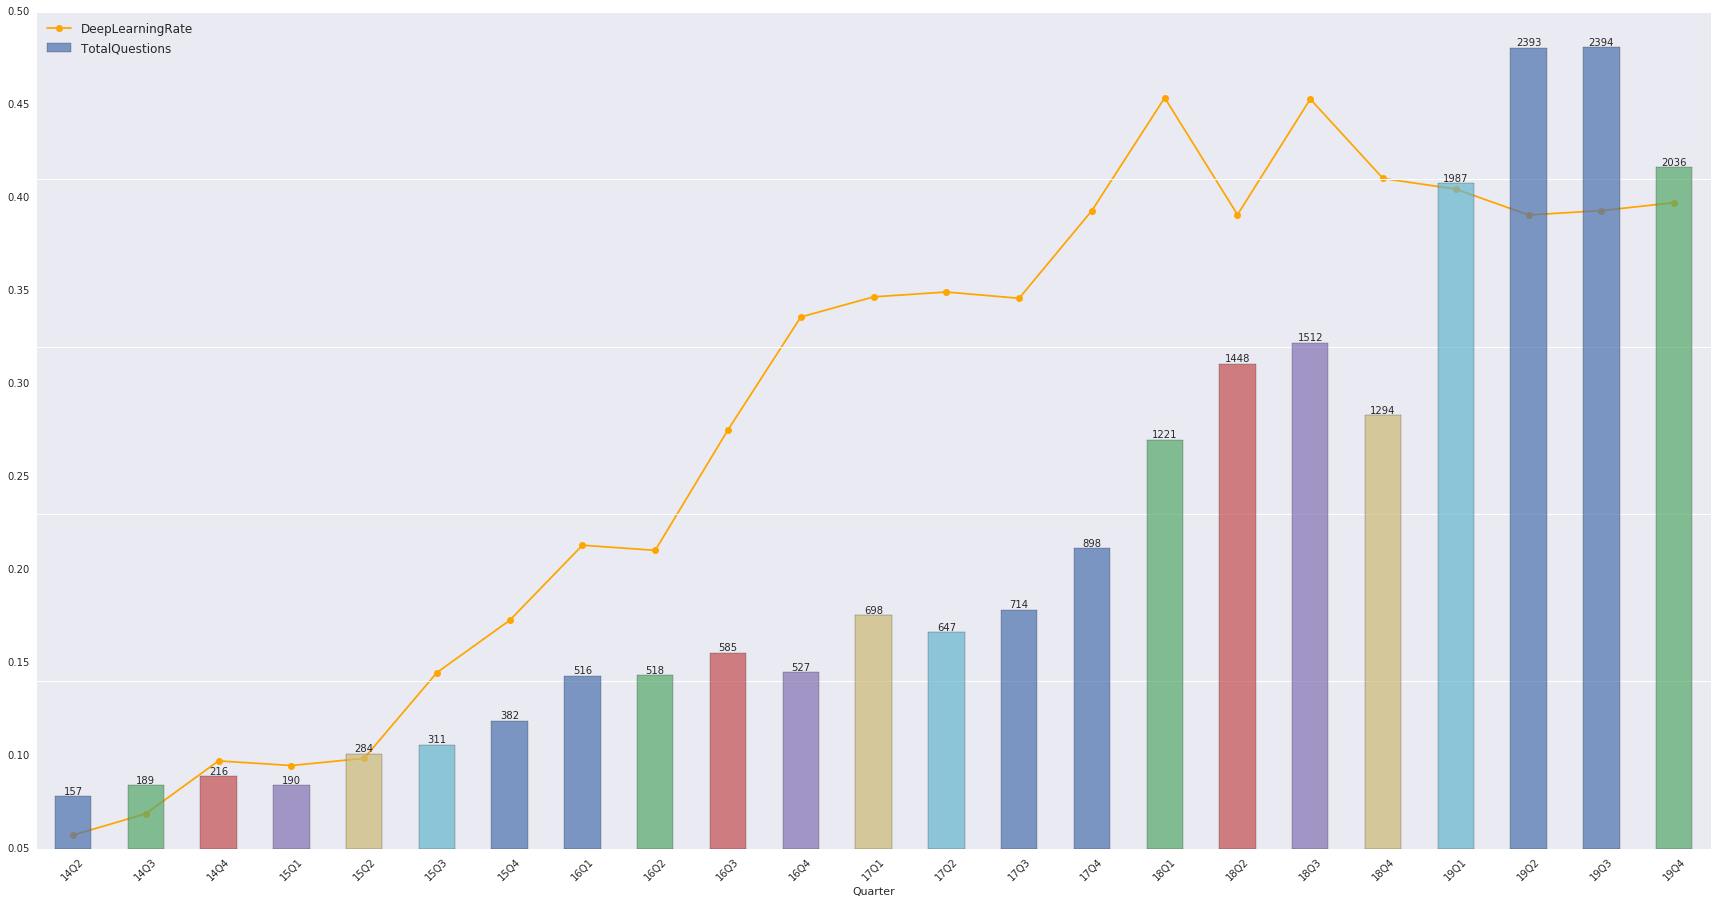

In [28]:
# The line chart representing Deep Learning Rate
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(30,15)
                    )

# The bar plot to respresnt the Total number of questions 
ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

# To label the bar plot with corresponding values
for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

# remove the legend
ax1.get_legend().remove()

# creating a new legend for our plots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})

# changing the position of the line plots axis
for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

The plot shows that over the years interest in Deep Learning has been increasing until recently where the interest has dropped a little and stagnated.